In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler


In [2]:
file_path='total_new.csv' ####
df=pd.read_csv(file_path)
df["Metadata_gene"]=df["Metadata_gene"].fillna('empty')


dfp=df[df['Metadata_control_type']=='negcon']
df=df[df['Metadata_control_type']!='negcon']
df=df[df['Metadata_gene']!='empty']
df=df[df["Metadata_experiment_type"]!='ORF']
# sampling
dd=(df['Metadata_gene'].value_counts())
dd1=dd.index.tolist()

import random
random.seed(1)
aa1=random.sample(dd1, 128)#####

z = []
for m in dd1:
    if m not in aa1:
        z.append(m)
dfcom=df[df['Metadata_experiment_type']=='Compound']
dfcom=dfcom[~dfcom['Metadata_pert_type'].isin(['control'])]

dftr1=dfcom[dfcom['Metadata_gene'].isin(aa1)]

dftr2=df[df['Metadata_experiment_type']=='CRISPR']
dftr2=dftr2[~dftr2['Metadata_pert_type'].isin(['control'])]

##### Only is list of plate is for mAP classifiation, so we filter it out
lst=['BR00116991','BR00116992','BR00116993','BR00116994','BR00117015','BR00117016','BR00117017','BR00117019','BR00116995','BR00117024','BR00117025','BR00117026','BR00117010','BR00117011','BR00117012','BR00117013']
dc=pd.DataFrame()
for i in lst:
    dc=pd.concat([dc,dftr1.loc[dftr1['Metadata_Plate']==i,:]])
dc0=pd.DataFrame()
for i in ['BR00116991','BR00116992','BR00116993','BR00116994']:
    dc0=pd.concat([dc0,dftr1.loc[dftr1['Metadata_Plate']==i,:]])
    
dc1=pd.DataFrame()
for i in ['BR00117015','BR00117016','BR00117017','BR00117019']:
    dc1=pd.concat([dc1,dftr1.loc[dftr1['Metadata_Plate']==i,:]])
    
dc2=pd.DataFrame()
for i in ['BR00116995','BR00117024','BR00117025','BR00117026']:
    dc2=pd.concat([dc2,dftr1.loc[dftr1['Metadata_Plate']==i,:]])
    
dc3=pd.DataFrame()
for i in ['BR00117010','BR00117011','BR00117012','BR00117013']:
    dc3=pd.concat([dc3,dftr1.loc[dftr1['Metadata_Plate']==i,:]])  
import random
teadd=pd.DataFrame()
for i in aa1:
    dc00=dc0.loc[dc0['Metadata_gene']==i,:]
    dc11=dc1.loc[dc1['Metadata_gene']==i,:]
    dc22=dc2.loc[dc2['Metadata_gene']==i,:]
    dc33=dc3.loc[dc3['Metadata_gene']==i,:]
    if len(dc00['Metadata_pert_iname'].unique())==2:
        ge=random.choice(dc00['Metadata_pert_iname'].unique())
        teadd=pd.concat([teadd,dc00[dc00['Metadata_pert_iname']==ge]])
   # else:
   #     print('else',len(dc00))
   #     print(dc00['Metadata_gene'].unique())
   #     print(dc00['Metadata_pert_iname'].unique())

    if len(dc11['Metadata_pert_iname'].unique())==2:
        ge=random.choice(dc11['Metadata_pert_iname'].unique())
        teadd=pd.concat([teadd,dc11[dc11['Metadata_pert_iname']==ge]])
    #else:
    #    print('else',len(dc11))
    #    print(dc11['Metadata_gene'].unique())
    #    print(dc11['Metadata_pert_iname'].unique())
        
    if len(dc22['Metadata_pert_iname'].unique())==2:
        ge=random.choice(dc22['Metadata_pert_iname'].unique())
        teadd=pd.concat([teadd,dc22[dc22['Metadata_pert_iname']==ge]])
    #else:
    #    print('else',len(dc22))
    #    print(dc22['Metadata_gene'].unique())
    #    print(dc22['Metadata_pert_iname'].unique())
        
    if len(dc33['Metadata_pert_iname'].unique())==2:
        ge=random.choice(dc33['Metadata_pert_iname'].unique())
        teadd=pd.concat([teadd,dc33[dc33['Metadata_pert_iname']==ge]])
    #else:
        #print('else',len(dc33))
        #print(dc33['Metadata_gene'].unique())
        #print(dc33['Metadata_pert_iname'].unique())
drolist=list(teadd['Unnamed: 0'].index)
dc1=dc.drop(index=drolist)
dfte1=teadd
dft=pd.concat([dc1,dftr2]) ###训练

/tmp/ipykernel_631920/1291667439.py:2: DtypeWarning: Columns (2,6,7,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(file_path)


In [3]:
dfte2=df[df['Metadata_gene'].isin(z)]
#dfte2=pd.concat([dfte2,dftr2])
dfte2=dfte2.drop_duplicates()
dfte2=dfte2[dfte2['Metadata_experiment_type']=='Compound']
#### SEEN
y_train=dft['Metadata_gene']
trainX=dft.drop('Metadata_gene', axis = 1)
dfte11=dfte1[dfte1['Metadata_gene']!='empty']
y_test=dfte11[dfte11['Metadata_experiment_type']=='Compound']['Metadata_gene']
testX=dfte11[dfte11['Metadata_experiment_type']=='Compound'].drop('Metadata_gene', axis = 1)
trainX=trainX.iloc[:,trainX.columns.get_loc("Cells_AreaShape_BoundingBoxMaximum_Y"):]
testX=testX.iloc[:,testX.columns.get_loc("Cells_AreaShape_BoundingBoxMaximum_Y"):]
trainX_final=trainX
testX_final=testX
trainY_final=y_train
testY_final=y_test
trainX=np.array(trainX)
testX=np.array(testX)
trainY=np.array(y_train)
testY=np.array(y_test)

In [4]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
scaler = sc.fit(trainX)
trainX_scaled = scaler.transform(trainX)
testX_scaled = scaler.transform(testX)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
mlp_clf = MLPClassifier(hidden_layer_sizes=(1280,630,300,178),
                        max_iter = 300,activation = 'relu',verbose=True, tol=1e-8,
                        solver = 'adam')

mlp_clf.fit(trainX_scaled, trainY)

Iteration 1, loss = 4.67408011
Iteration 2, loss = 3.89654980
Iteration 3, loss = 3.28502376
Iteration 4, loss = 2.74695110
Iteration 5, loss = 2.26999001
Iteration 6, loss = 1.89459906
Iteration 7, loss = 1.54130822
Iteration 8, loss = 1.23576276
Iteration 9, loss = 0.97543388
Iteration 10, loss = 0.70223624
Iteration 11, loss = 0.49782040
Iteration 12, loss = 0.39666972
Iteration 13, loss = 0.28881335
Iteration 14, loss = 0.29937845
Iteration 15, loss = 0.23942567
Iteration 16, loss = 0.19349408
Iteration 17, loss = 0.17829833
Iteration 18, loss = 0.11396634
Iteration 19, loss = 0.10311369
Iteration 20, loss = 0.08307073
Iteration 21, loss = 0.04327629
Iteration 22, loss = 0.03670054
Iteration 23, loss = 0.02502610
Iteration 24, loss = 0.01156500
Iteration 25, loss = 0.00662398
Iteration 26, loss = 0.00616856
Iteration 27, loss = 0.00608707
Iteration 28, loss = 0.00361387
Iteration 29, loss = 0.00288252
Iteration 30, loss = 0.00264283
Iteration 31, loss = 0.00251729
Iteration 32, los

/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(1280, 630, 300, 178), max_iter=300, tol=1e-08,
              verbose=True)

These below are MLP Classification

In [5]:
sc=StandardScaler()
scaler = sc.fit(trainX)
trainX_scaled = scaler.transform(trainX)
testX_scaled = scaler.transform(testX)
y_pred = mlp_clf.predict(testX_scaled)
print('Seen')
print(classification_report(testY, y_pred))

Seen
              precision    recall  f1-score   support

         ADA       0.33      0.12      0.18        16
       ADH1C       0.11      0.06      0.08        16
     ADORA2A       0.00      0.00      0.00        16
      ADRA2B       0.15      0.12      0.14        16
        AGER       0.23      0.20      0.21        15
      AKR1B1       0.17      0.06      0.09        16
      AKR1C1       0.11      0.13      0.12        15
       ALDH2       0.11      0.12      0.11        16
         ALK       0.53      0.56      0.55        16
       ANXA1       0.00      0.00      0.00         0
       ASIC1       0.12      0.06      0.08        16
         ATM       0.38      0.19      0.25        16
     ATP5F1D       0.15      0.12      0.14        16
      AVPR1A       1.00      0.06      0.12        16
         BAX       0.00      0.00      0.00         0
        CA14       0.23      0.19      0.21        16
        CA5A       0.38      0.53      0.44        15
    CACNA2D3       0.0

/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
####SEEN
report=classification_report(testY, y_pred,output_dict=True)
df1=pd.DataFrame(report).transpose()[['recall']]
df1.rename(columns={'recall': 'Recall'},inplace=True)
df1.drop(['micro avg','macro avg','weighted avg'],axis=0,errors='ignore',inplace = True)
df1.index.name='Label'
df1=df1[df1.index.isin(pd.Series(testY).unique())]

/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
#### UNSEEN
dfte22=dfte2[dfte2['Metadata_gene']!='empty']
y_test=dfte22[dfte22['Metadata_experiment_type']=='Compound']['Metadata_gene']
testX=dfte22[dfte22['Metadata_experiment_type']=='Compound'].drop('Metadata_gene', axis = 1)
testX=testX.iloc[:,testX.columns.get_loc("Cells_AreaShape_BoundingBoxMaximum_Y"):]
testX_final=testX
testY_final=y_test
testX=np.array(testX)
testY=np.array(y_test)
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
scaler = sc.fit(trainX)
testX_scaled = scaler.transform(testX)

In [8]:
y_pred = mlp_clf.predict(testX_scaled)

print('Unseen Accuracy: {:.2f}'.format(accuracy_score(testY, y_pred)))
print(classification_report(testY, y_pred))

Unseen Accuracy: 0.01
              precision    recall  f1-score   support

        ABL1       0.00      0.00      0.00        48
         ADA       0.00      0.00      0.00         0
       ADH1C       0.00      0.00      0.00         0
     ADORA2A       0.00      0.00      0.00         0
      ADRA2B       0.00      0.00      0.00         0
        AGER       0.00      0.00      0.00         0
      AKR1B1       0.00      0.00      0.00         0
      AKR1C1       0.00      0.00      0.00         0
        AKT1       0.00      0.00      0.00        47
       ALDH2       0.00      0.00      0.00         0
         ALK       0.00      0.00      0.00         0
       ANXA1       0.00      0.00      0.00         0
       ASIC1       0.00      0.00      0.00         0
         ATM       0.00      0.00      0.00         0
     ATP5F1D       0.00      0.00      0.00         0
       AURKB       0.00      0.00      0.00        48
      AVPR1A       0.00      0.00      0.00         0
     

/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

In [9]:
report2=classification_report(testY, y_pred,output_dict=True)
df2=pd.DataFrame(report2).transpose()[['recall']]
df2.rename(columns={'recall': 'Recall'},inplace=True)
df2.drop(['micro avg','macro avg','weighted avg'],axis=0,errors='ignore',inplace = True)
df2.index.name='Label'
df2=df2[df2.index.isin(pd.Series(testY).unique())]
df1['If_seen']='seen'
df2['If_seen']='unseen'

/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

In [10]:
df3=pd.concat([df1,df2])
df3=df3.dropna()
print('AVG Seen ACC',df1['Recall'].mean())
print('AVG Unseen ACC',df2['Recall'].mean())
print('AVG ALL ACC',df3['Recall'].mean())
df3=df3.sort_values(by='Recall', ascending = False)
df3=df3.iloc[:10,:]

AVG Seen ACC 0.1787083333333333
AVG Unseen ACC 0.010485926418439716
AVG ALL ACC 0.1379271437782076


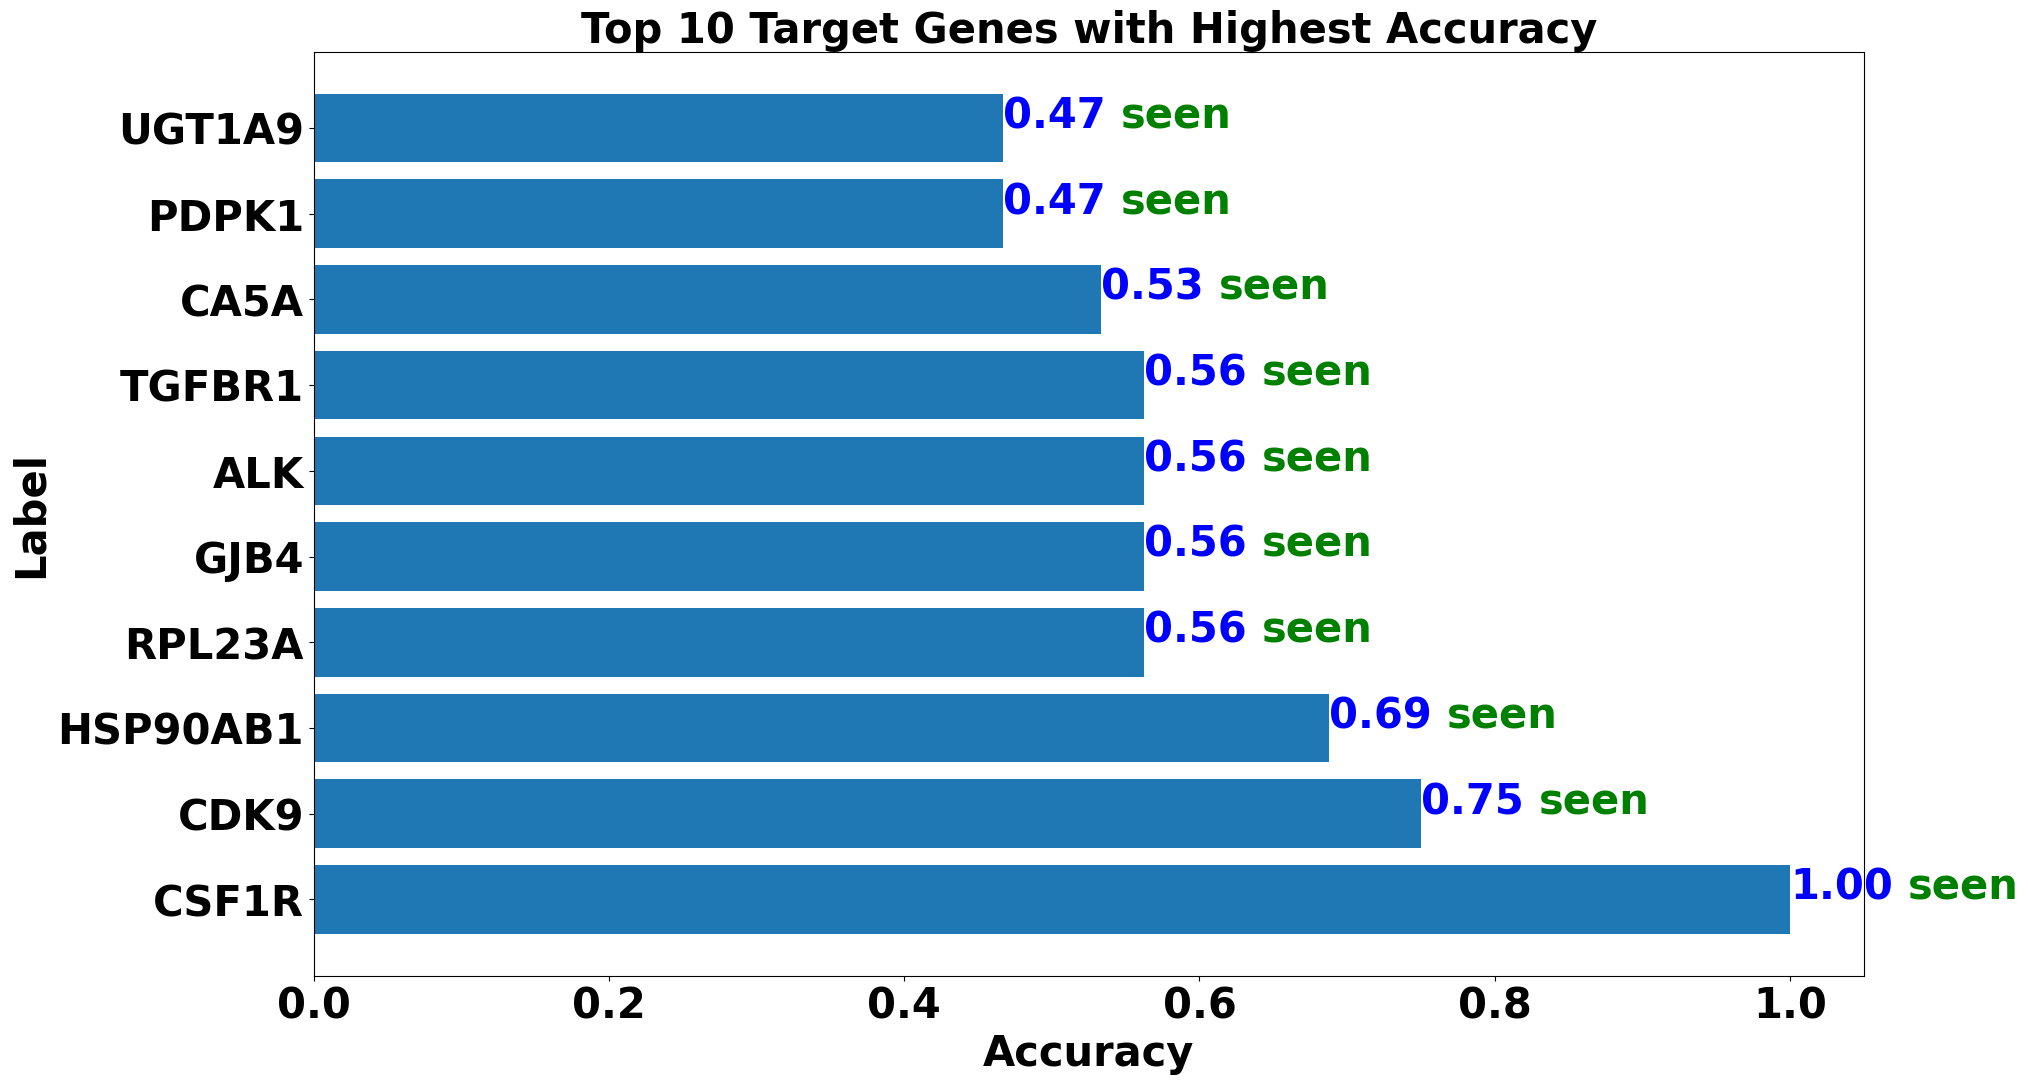

In [11]:
### TOP 10
plt.figure(figsize=(20,12))
plt.barh(df3.index,df3['Recall'])
plt.xlabel('Accuracy',fontweight = 'bold',fontsize=30)
plt.ylabel('Label',fontweight = 'bold',fontsize=30)
plt.yticks(fontweight = 'bold',fontsize=30)
plt.xticks(fontweight = 'bold',fontsize=30)
plt.title('Top 10 Target Genes with Highest Accuracy',fontweight = 'bold',fontsize=30)
for i,(v,s) in enumerate(zip(df3['Recall'],df3['If_seen'])):
    plt.text(v,i,f'{v:.2f}', color = 'blue', fontweight = 'bold',fontsize=30)
    plt.text(v+0.08, i, s, color = 'green', fontweight = 'bold',fontsize=30)
plt.show()

In [12]:
#########Feature Transformation for 1-NN Classification
import torch
import torch.nn as nn
relu = nn.ReLU(inplace=True)
ww=df
ww1=ww.iloc[:,ww.columns.get_loc("Cells_AreaShape_BoundingBoxMaximum_Y"):]
sc=StandardScaler()
scaler = sc.fit(ww1)
ww1_scaled = scaler.transform(ww1)
a11=np.array(relu(torch.from_numpy(np.dot(ww1_scaled,mlp_clf.coefs_[0])+mlp_clf.intercepts_[0])))
a22=np.array(relu(torch.from_numpy(np.dot(a11,mlp_clf.coefs_[1])+mlp_clf.intercepts_[1])))
a33=np.array(relu(torch.from_numpy(np.dot(a22,mlp_clf.coefs_[2])+mlp_clf.intercepts_[2])))
ww2=ww.iloc[:,0:ww.columns.get_loc("Cells_AreaShape_BoundingBoxMaximum_Y")]
ww_n=pd.DataFrame(a33)
ww_n.index=ww2.index

# features after MLP transformation
feature_new =pd.concat([ww2,ww_n,ww['Metadata_experiment_type']], axis=1)
df1=feature_new

In [13]:
df1=feature_new
df1=df1.iloc[:,1:-1]
df11=df1[df1['Metadata_experiment_type']=='Compound']
df11.to_csv('/data/datacenter/H3C_GPU/projects/yuchen/gzsda-main/gzsda-main/data/XrayBaggage20/Compound.csv')

In [14]:
##These are used to train CCVAE
df22=df1[df1['Metadata_experiment_type']=='CRISPR']
df22.to_csv('/data/datacenter/H3C_GPU/projects/yuchen/gzsda-main/gzsda-main/data/XrayBaggage20/CRISPR.csv')

In [15]:
feature_new=feature_new.reset_index()
dfte1=dfte1.reset_index()
dfte2=dfte2.reset_index()

In [16]:
dfte1=dfte1.iloc[:,2:]
dfte2=dfte2.iloc[:,2:]
feature_new=feature_new.iloc[:,2:]

In [17]:
import torch
import torch.nn as nn
relu = nn.ReLU(inplace=True)
ww=dfte1
ww1=ww.iloc[:,ww.columns.get_loc("Cells_AreaShape_BoundingBoxMaximum_Y"):]
sc=StandardScaler()
scaler = sc.fit(ww1)
ww1_scaled = scaler.transform(ww1)
a11=np.array(relu(torch.from_numpy(np.dot(ww1_scaled,mlp_clf.coefs_[0])+mlp_clf.intercepts_[0])))
a22=np.array(relu(torch.from_numpy(np.dot(a11,mlp_clf.coefs_[1])+mlp_clf.intercepts_[1])))
a33=np.array(relu(torch.from_numpy(np.dot(a22,mlp_clf.coefs_[2])+mlp_clf.intercepts_[2])))
ww2=ww.iloc[:,0:ww.columns.get_loc("Cells_AreaShape_BoundingBoxMaximum_Y")]
ww_n=pd.DataFrame(a33)
ww_n.index=ww2.index

# features after MLP transformation
feature_new =pd.concat([ww2,ww_n,ww['Metadata_experiment_type']], axis=1)
dfte1a=feature_new

In [18]:
import torch
import torch.nn as nn
relu = nn.ReLU(inplace=True)
ww=dfte2
ww1=ww.iloc[:,ww.columns.get_loc("Cells_AreaShape_BoundingBoxMaximum_Y"):]
sc=StandardScaler()
scaler = sc.fit(ww1)
ww1_scaled = scaler.transform(ww1)
a11=np.array(relu(torch.from_numpy(np.dot(ww1_scaled,mlp_clf.coefs_[0])+mlp_clf.intercepts_[0])))
a22=np.array(relu(torch.from_numpy(np.dot(a11,mlp_clf.coefs_[1])+mlp_clf.intercepts_[1])))
a33=np.array(relu(torch.from_numpy(np.dot(a22,mlp_clf.coefs_[2])+mlp_clf.intercepts_[2])))
ww2=ww.iloc[:,0:ww.columns.get_loc("Cells_AreaShape_BoundingBoxMaximum_Y")]
ww_n=pd.DataFrame(a33)
ww_n.index=ww2.index

# features after MLP transformation
feature_new =pd.concat([ww2,ww_n,ww['Metadata_experiment_type']], axis=1)
dfte2a=feature_new

These below is for 1-NN Classification

In [19]:
import torch
import torch.nn as nn
relu = nn.ReLU(inplace=True)
ww=dft

ww1=ww.iloc[:,ww.columns.get_loc("Cells_AreaShape_BoundingBoxMaximum_Y"):]

sc=StandardScaler()
scaler = sc.fit(ww1)
ww1_scaled = scaler.transform(ww1)
a11=np.array(relu(torch.from_numpy(np.dot(ww1_scaled,mlp_clf.coefs_[0])+mlp_clf.intercepts_[0])))
a22=np.array(relu(torch.from_numpy(np.dot(a11,mlp_clf.coefs_[1])+mlp_clf.intercepts_[1])))
a33=np.array(relu(torch.from_numpy(np.dot(a22,mlp_clf.coefs_[2])+mlp_clf.intercepts_[2])))
ww2=ww.iloc[:,0:ww.columns.get_loc("Cells_AreaShape_BoundingBoxMaximum_Y")]
ww_n=pd.DataFrame(a33)
ww_n.index=ww2.index

# features after transformation
'''
features = ww_n
features_norm = features.apply(lambda x: x/np.linalg.norm(x))
features_demean = features_norm - features_norm_mean
features_demean.index=ww2.index
'''

dftt =pd.concat([ww2,ww_n,ww['Metadata_experiment_type']], axis=1)

y_train=dftt['Metadata_gene']
trainX=dftt.drop('Metadata_gene', axis = 1)
trainX=trainX.iloc[:,trainX.columns.get_loc(0):]
from sklearn.neighbors import KNeighborsClassifier
y_test=dfte1a['Metadata_gene']
testX=dfte1a.drop('Metadata_gene', axis = 1)
testX=testX.iloc[:,testX.columns.get_loc(0):]
testX=testX.iloc[:,:-1]

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_train)
lst=[]
lst1=[]
knn = KNeighborsClassifier(n_neighbors=1)
trainX.columns = trainX.columns.astype(str)
trainX=trainX.iloc[:,:-1]
knn.fit(trainX,y_train)

# make predictions on the test set
y_pred = knn.predict(testX)

# decode the predicted and true labels to get the actual class names

class_names = le.inverse_transform(list(range(len(le.classes_))))

# compute the accuracy, precision, recall, and F1-score for each class

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)

# print the accuracy score for each class
'''
print('Average Accuracy:',sum(precision)/len(precision))
print('')
for i in range(len(precision)):
    #lst=lst.append(class_names[i])
    #lst1=lst1.append(precision[i])
    print(f"Class {class_names[i]}:")
    print(f"Accuracy score: {precision[i]:.3f}")
    print(f"Recall score: {recall[i]:.3f}")
    print(f"F-1 score: {f1[i]:.3f}")
'''
print('Seen')
print(classification_report(y_test, y_pred))

/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Seen
              precision    recall  f1-score   support

        ABL1       0.00      0.00      0.00         0
         ADA       0.42      0.50      0.46        16
       ADH1C       0.00      0.00      0.00        16
     ADORA2A       0.00      0.00      0.00        16
      ADRA2B       0.12      0.12      0.12        16
        AGER       0.10      0.07      0.08        15
      AKR1B1       0.00      0.00      0.00        16
      AKR1C1       0.17      0.27      0.21        15
       ALDH2       0.06      0.06      0.06        16
         ALK       0.40      0.62      0.49        16
       ANXA1       0.00      0.00      0.00         0
       ASIC1       0.00      0.00      0.00        16
         ATM       0.00      0.00      0.00        16
     ATP5F1D       0.15      0.12      0.14        16
      AVPR1A       0.28      0.31      0.29        16
         BAX       0.00      0.00      0.00         0
         BTK       0.00      0.00      0.00         0
        CA14       0.1

/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yuchen.

In [21]:
report3=classification_report(y_test, y_pred,output_dict=True)
df22=pd.DataFrame(report3).transpose()[['recall']]
df22.rename(columns={'recall': 'Recall'},inplace=True)
df22.drop(['micro avg','macro avg','weighted avg'],axis=0,errors='ignore',inplace = True)
df22.index.name='Label'
df22=df22[df22.index.isin(dfte1['Metadata_gene'].unique())]
df22['If_seen']='seen'

/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
y_test=dfte2a['Metadata_gene']
testX=dfte2a.drop('Metadata_gene', axis = 1)
testX=testX.iloc[:,testX.columns.get_loc(0):]
testX=testX.iloc[:,:-1]
# make predictions on the test set
y_pred = knn.predict(testX)

# decode the predicted and true labels to get the actual class names
class_names = le.inverse_transform(list(range(len(le.classes_))))

# compute the accuracy, precision, recall, and F1-score for each class

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)
#print('Average Accuracy:',sum(precision)/len(precision))
#print('')
# print the accuracy score for each class
'''
for i in range(len(precision)):
    print(f"Class {class_names[i]}:")
    print(f"Accuracy score: {precision[i]:.3f}")
    print(f"Recall score: {recall[i]:.3f}")
    print(f"F-1 score: {f1[i]:.3f}")
print('Average Accuracy:',sum(precision)/len(precision))

'''
print('Unseen')
print(classification_report(y_test, y_pred))

/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Unseen
              precision    recall  f1-score   support

        ABL1       0.00      0.00      0.00        48
         ADA       0.00      0.00      0.00         0
       ADH1C       0.00      0.00      0.00         0
     ADORA2A       0.00      0.00      0.00         0
      ADRA2B       0.00      0.00      0.00         0
        AGER       0.00      0.00      0.00         0
      AKR1C1       0.00      0.00      0.00         0
        AKT1       0.00      0.00      0.00        47
       ALDH2       0.00      0.00      0.00         0
         ALK       0.00      0.00      0.00         0
       ANXA1       0.00      0.00      0.00         0
       ASIC1       0.00      0.00      0.00         0
         ATM       0.00      0.00      0.00         0
     ATP5F1D       0.00      0.00      0.00         0
       AURKB       0.00      0.00      0.00        48
      AVPR1A       0.00      0.00      0.00         0
         BAX       0.50      0.04      0.08        47
         BTK       0

/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

In [23]:
report4=classification_report(y_test, y_pred,output_dict=True)
df33=pd.DataFrame(report4).transpose()[['recall']]
df33.rename(columns={'recall': 'Recall'},inplace=True)
df33.drop(['micro avg','macro avg','weighted avg'],axis=0,errors='ignore',inplace = True)
df33.index.name='Label'
df33=df33[df33.index.isin(dfte2['Metadata_gene'].unique())]
df33['If_seen']='unseen'

/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

In [24]:
df44=pd.concat([df22,df33])
df44=df44.dropna()
print('AVG_Seen_ACC',df22['Recall'].mean())
print('AVG_Unseen_ACC',df33['Recall'].mean())
print('AVG_ALL_ACC',df44['Recall'].mean())
df44=df44.sort_values(by='Recall', ascending = False)
df44=df44.iloc[:10,:]

AVG_Seen_ACC 0.16125
AVG_Unseen_ACC 0.009834884751773049
AVG_ALL_ACC 0.12454330539436922


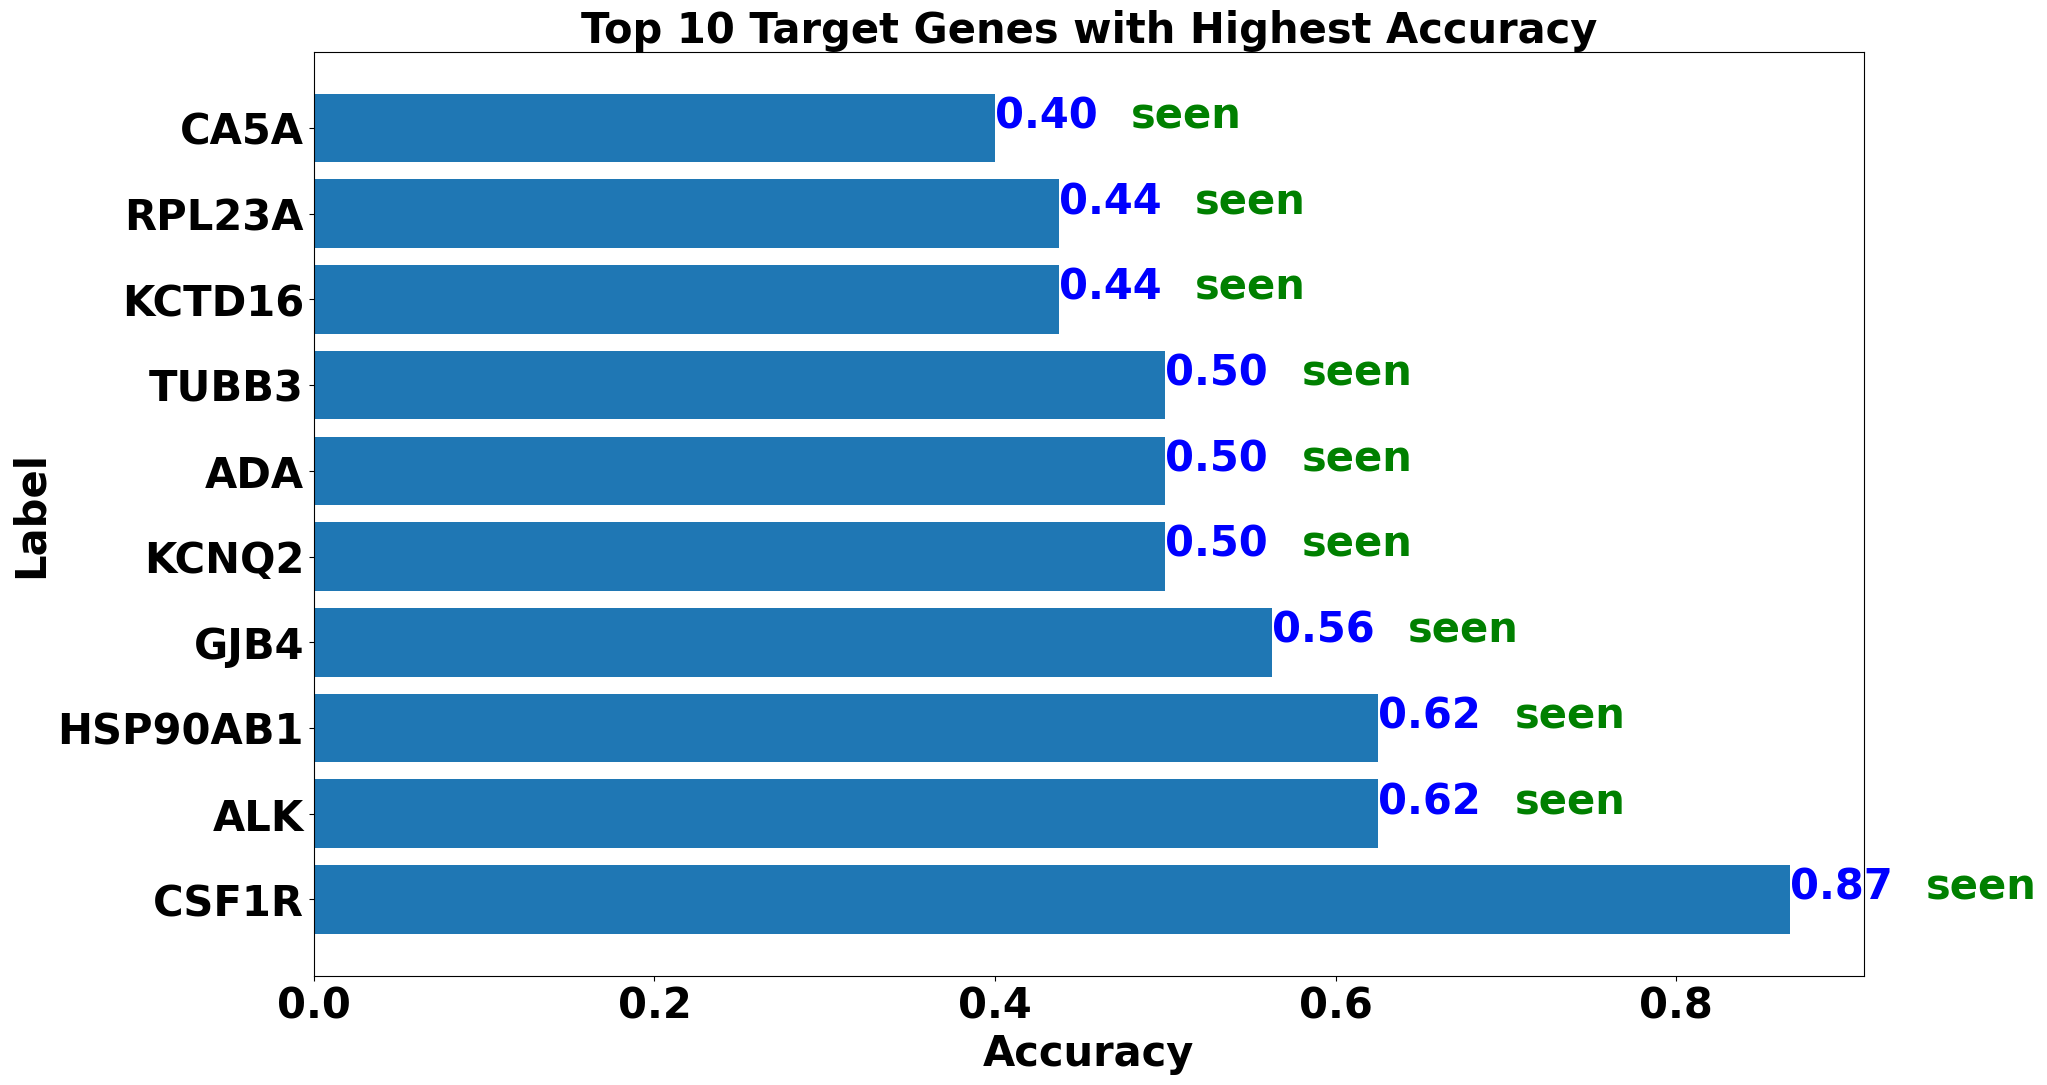

In [25]:
### TOP 10
plt.figure(figsize=(20,12))
plt.barh(df44.index,df44['Recall'])
plt.xlabel('Accuracy',fontweight = 'bold',fontsize=30)
plt.ylabel('Label',fontweight = 'bold',fontsize=30)
plt.yticks(fontweight = 'bold',fontsize=30)
plt.xticks(fontweight = 'bold',fontsize=30)
plt.title('Top 10 Target Genes with Highest Accuracy',fontweight = 'bold',fontsize=30)
for i,(v,s) in enumerate(zip(df44['Recall'],df44['If_seen'])):
    plt.text(v,i,f'{v:.2f}', color = 'blue', fontweight = 'bold',fontsize=30)
    plt.text(v+0.08, i, s, color = 'green', fontweight = 'bold',fontsize=30)
plt.show()

This is for SLPP

In [26]:
###### SEEN
file_path='total_new.csv' ####
df=pd.read_csv(file_path)
df["Metadata_gene"]=df["Metadata_gene"].fillna('empty')


dfp=df[df['Metadata_control_type']=='negcon']
df=df[df['Metadata_control_type']!='negcon']
df=df[df['Metadata_gene']!='empty']
df=df[df["Metadata_experiment_type"]!='ORF']
# sampling
dd=(df['Metadata_gene'].value_counts())
dd1=dd.index.tolist()

import random
random.seed(1)
aa1=random.sample(dd1, 128)#####

z = []
for m in dd1:
    if m not in aa1:
        z.append(m)
dfcom=df[df['Metadata_experiment_type']=='Compound']
dfcom=dfcom[~dfcom['Metadata_pert_type'].isin(['control'])]

dftr1=dfcom[dfcom['Metadata_gene'].isin(aa1)]

dftr2=df[df['Metadata_experiment_type']=='CRISPR']
dftr2=dftr2[~dftr2['Metadata_pert_type'].isin(['control'])]
lst=['BR00116991','BR00116992','BR00116993','BR00116994','BR00117015','BR00117016','BR00117017','BR00117019','BR00116995','BR00117024','BR00117025','BR00117026','BR00117010','BR00117011','BR00117012','BR00117013']
dc=pd.DataFrame()
for i in lst:
    dc=pd.concat([dc,dftr1.loc[dftr1['Metadata_Plate']==i,:]])
dc0=pd.DataFrame()
for i in ['BR00116991','BR00116992','BR00116993','BR00116994']:
    dc0=pd.concat([dc0,dftr1.loc[dftr1['Metadata_Plate']==i,:]])
    
dc1=pd.DataFrame()
for i in ['BR00117015','BR00117016','BR00117017','BR00117019']:
    dc1=pd.concat([dc1,dftr1.loc[dftr1['Metadata_Plate']==i,:]])
    
dc2=pd.DataFrame()
for i in ['BR00116995','BR00117024','BR00117025','BR00117026']:
    dc2=pd.concat([dc2,dftr1.loc[dftr1['Metadata_Plate']==i,:]])
    
dc3=pd.DataFrame()
for i in ['BR00117010','BR00117011','BR00117012','BR00117013']:
    dc3=pd.concat([dc3,dftr1.loc[dftr1['Metadata_Plate']==i,:]])  
import random
teadd=pd.DataFrame()
for i in aa1:
    dc00=dc0.loc[dc0['Metadata_gene']==i,:]
    dc11=dc1.loc[dc1['Metadata_gene']==i,:]
    dc22=dc2.loc[dc2['Metadata_gene']==i,:]
    dc33=dc3.loc[dc3['Metadata_gene']==i,:]
    if len(dc00['Metadata_pert_iname'].unique())==2:
        ge=random.choice(dc00['Metadata_pert_iname'].unique())
        teadd=pd.concat([teadd,dc00[dc00['Metadata_pert_iname']==ge]])
    else:
        print('else',len(dc00))
        print(dc00['Metadata_gene'].unique())
        print(dc00['Metadata_pert_iname'].unique())

    if len(dc11['Metadata_pert_iname'].unique())==2:
        ge=random.choice(dc11['Metadata_pert_iname'].unique())
        teadd=pd.concat([teadd,dc11[dc11['Metadata_pert_iname']==ge]])
    else:
        print('else',len(dc11))
        print(dc11['Metadata_gene'].unique())
        print(dc11['Metadata_pert_iname'].unique())
        
    if len(dc22['Metadata_pert_iname'].unique())==2:
        ge=random.choice(dc22['Metadata_pert_iname'].unique())
        teadd=pd.concat([teadd,dc22[dc22['Metadata_pert_iname']==ge]])
    else:
        print('else',len(dc22))
        print(dc22['Metadata_gene'].unique())
        print(dc22['Metadata_pert_iname'].unique())
        
    if len(dc33['Metadata_pert_iname'].unique())==2:
        ge=random.choice(dc33['Metadata_pert_iname'].unique())
        teadd=pd.concat([teadd,dc33[dc33['Metadata_pert_iname']==ge]])
    else:
        print('else',len(dc33))
        print(dc33['Metadata_gene'].unique())
        print(dc33['Metadata_pert_iname'].unique())
        
drolist=list(teadd['Unnamed: 0'].index)
dc1=dc.drop(index=drolist)
dfte1=teadd
dft=pd.concat([dc1,dftr2]) ###训练
dfte2=df[df['Metadata_gene'].isin(z)]
#dfte2=pd.concat([dfte2,dftr2])
dfte2=dfte2[dfte2['Metadata_experiment_type']=='Compound']
dfte2=dfte2.drop_duplicates()
#### SEEN
y_train=dft['Metadata_gene']
trainX=dft.drop('Metadata_gene', axis = 1)
dfte11=dfte1[dfte1['Metadata_gene']!='empty']
y_test=dfte11[dfte11['Metadata_experiment_type']=='Compound']['Metadata_gene']
testX=dfte11[dfte11['Metadata_experiment_type']=='Compound'].drop('Metadata_gene', axis = 1)
trainX=trainX.iloc[:,trainX.columns.get_loc("Cells_AreaShape_BoundingBoxMaximum_Y"):]
testX=testX.iloc[:,testX.columns.get_loc("Cells_AreaShape_BoundingBoxMaximum_Y"):]
trainX_final=trainX
testX_final=testX
trainY_final=y_train
testY_final=y_test


trainX=np.array(trainX)
testX=np.array(testX)
trainY=np.array(y_train)
testY=np.array(y_test)

/tmp/ipykernel_631920/3921620276.py:3: DtypeWarning: Columns (2,6,7,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(file_path)


else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 8
['PTPN2']
['BVT-948']
else 8
['PTPN2']
['BVT-948']
else 8
['PTPN2']
['BVT-948']
else 8
['PTPN2']
['BVT-948']
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 8
['ANXA1']
['dexamethasone']
else 8
['ANXA1']


In [27]:
n_components=300
sigma=1.0

In [28]:
    # Standardize the data
    X_train = StandardScaler().fit_transform(trainX)
    y_train=trainY
    # Compute the pairwise distance matrix
    D = np.zeros((X_train.shape[0], X_train.shape[0]))
    for i in range(X_train.shape[0]):
        for j in range(X_train.shape[0]):
            D[i, j] = np.linalg.norm(X_train[i] - X_train[j])

    # Compute the adjacency graph using a Gaussian kernel
    W = np.zeros((X_train.shape[0], X_train.shape[0]))
    for i in range(X_train.shape[0]):
        for j in range(X_train.shape[0]):
            W[i, j] = np.exp(-D[i, j] ** 2 / (2 * sigma ** 2)) * (y_train[i] == y_train[j])

    # Compute the degree matrix
    D = np.diag(np.sum(W, axis=1))

    # Compute the Laplacian matrix
    L = D - W

    # Compute the eigenvectors
    eigvals, eigvecs = np.linalg.eig(np.dot(np.dot(X_train.T, L), X_train))

    # Sort the eigenvectors by eigenvalues in descending order
    sort_indices = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, sort_indices]

    # Select the first n_components eigenvectors
    eigvecs = eigvecs[:, :n_components]
    eigvecs=np.real(eigvecs)

In [29]:
transformed_data1 = np.dot(dft.iloc[:,15:], eigvecs)
X2=pd.DataFrame(transformed_data1)
ttX1=dft.iloc[:,:dft.columns.get_loc("Cells_AreaShape_BoundingBoxMaximum_Y")]
ttX1=ttX1.reset_index()
#dfnew=pd.concat([testX1,X2],axis=1)

'''
features = X2
features_norm = features.apply(lambda x: x/np.linalg.norm(x))
features_demean = features_norm - features_norm_mean
'''
dfttt =pd.concat([ttX1,X2],axis=1)
dfttt

,index,Unnamed: 0,Metadata_broad_sample,Metadata_solvent,Metadata_experiment_type,Metadata_Plate,Metadata_Well,Metadata_InChIKey,Metadata_pert_iname,Metadata_pubchem_cid,...,290,291,292,293,294,295,296,297,298,299
0,12674,4,BRD-K48278478-001-01-2,DMSO,Compound,BR00116991,A05,LOUPRKONTZGTKE-AFHBHXEDSA-N,quinine,94175.0,...,14.440410,-20.621535,-6.186848,21.428882,-13.768617,-3.171128,-8.465376,-11.083806,5.479511,13.949678
1,12676,6,BRD-K74913225-001-14-0,DMSO,Compound,BR00116991,A07,HCRKCZRJWPKOAR-JTQLQIEISA-N,brinzolamide,68844.0,...,1.226439,-2.956875,-1.602464,5.220073,2.528694,1.645733,-2.861502,-2.715075,5.973549,3.547608
2,12677,7,BRD-K94342292-001-01-3,DMSO,Compound,BR00116991,A08,MDKAFDIKYQMOMF-UHFFFAOYSA-N,NS-11021,24826000.0,...,1.474121,-4.423878,-1.736677,5.209963,1.967729,2.127357,-3.626638,-3.198621,6.645688,4.430409
3,12679,9,BRD-K19975102-001-01-2,DMSO,Compound,BR00116991,A10,YYDUWLSETXNJJT-MTJSOVHGSA-N,GNF-5837,59397000.0,...,1.412409,-1.109456,-0.315734,-0.065221,0.930200,0.390491,-0.111788,-0.042206,-0.424219,0.436228
4,12680,10,BRD-K25244359-066-02-6,DMSO,Compound,BR00116991,A11,WPEWQEMJFLWMLV-UHFFFAOYSA-N,apatinib,11315000.0,...,1.338213,0.191213,0.857555,0.675725,0.454778,-0.203274,-0.347392,-0.360387,-0.263079,-0.172328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6376,18341,379,BRDN0001145303,NaN,CRISPR,BR00118045,P20,NaN,NaN,NaN,...,-1.327996,-0.375310,-0.654806,1.092318,-0.465208,-0.836380,-0.938255,0.287515,-0.991861,0.847866
6377,18342,380,BRDN0001484228,NaN,CRISPR,BR00118045,P21,NaN,NaN,NaN,...,-1.134673,-0.104076,-0.411719,0.245082,-1.370825,-0.667759,0.064087,-0.905993,-1.034073,0.262891
6378,18343,381,BRDN0001487618,NaN,CRISPR,BR00118045,P22,NaN,NaN,NaN,...,-1.709499,-0.310141,-0.152801,0.556908,-0.331192,0.118870,-0.758077,-0.091067,-0.853418,1.396384
6379,18344,382,BRDN0001487864,NaN,CRISPR,BR00118045,P23,NaN,NaN,NaN,...,-2.013939,-0.347968,-0.875679,0.055815,-0.863727,0.300525,-2.211011,-0.087342,0.591182,0.200835


In [30]:
transformed_data = np.dot(testX, eigvecs)
c = dfte1.pop('Metadata_experiment_type')             #pop出一个Series
dfte1.insert(3,'Metadata_experiment_type',c)   #相当于在第4列的位置，添加列名为c_new的列c
X2=pd.DataFrame(transformed_data)
testX1=dfte1.iloc[:,:dfte1.columns.get_loc("Cells_AreaShape_BoundingBoxMaximum_Y")]
testX1=testX1.reset_index()
#dfnew=pd.concat([testX1,X2],axis=1)

'''
features = X2
features_norm = features.apply(lambda x: x/np.linalg.norm(x))
features_demean = features_norm - features_norm_mean
'''
dfnew1 =pd.concat([testX1,X2],axis=1)

In [31]:
y_train=dfttt['Metadata_gene']
trainX=dfttt.drop('Metadata_gene', axis = 1)
trainX=trainX.iloc[:,trainX.columns.get_loc(0):]
from sklearn.neighbors import KNeighborsClassifier
y_test=dfnew1['Metadata_gene']
testX=dfnew1.drop('Metadata_gene', axis = 1)
testX=testX.iloc[:,testX.columns.get_loc(0):]

In [32]:
y_train

0        KCNN4
1         CA5A
2       KCNMA1
3        NTRK1
4          CSK
         ...  
6376      ABL1
6377    GPR119
6378     OPRM1
6379     S1PR1
6380    TGFBR1
Name: Metadata_gene, Length: 6381, dtype: object

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_train)
lst=[]
lst1=[]
knn = KNeighborsClassifier(n_neighbors=1)
trainX.columns = trainX.columns.astype(str)
knn.fit(trainX,y_train)

# make predictions on the test set
y_pred = knn.predict(testX)

# decode the predicted and true labels to get the actual class names

class_names = le.inverse_transform(list(range(len(le.classes_))))

# compute the accuracy, precision, recall, and F1-score for each class

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)

# print the accuracy score for each class
'''
print('Average Accuracy:',sum(precision)/len(precision))
print('')
for i in range(len(precision)):
    #lst=lst.append(class_names[i])
    #lst1=lst1.append(precision[i])
    print(f"Class {class_names[i]}:")
    print(f"Accuracy score: {precision[i]:.3f}")
    print(f"Recall score: {recall[i]:.3f}")
    print(f"F-1 score: {f1[i]:.3f}")
'''
print('Accuracy:')
print(classification_report(y_test, y_pred))

/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Accuracy:
              precision    recall  f1-score   support

        ABL1       0.00      0.00      0.00         0
         ADA       0.40      0.50      0.44        16
       ADH1C       0.14      0.06      0.09        16
     ADORA2A       0.00      0.00      0.00        16
      ADRA2B       0.00      0.00      0.00        16
        AGER       0.00      0.00      0.00        15
      AKR1B1       0.00      0.00      0.00        16
      AKR1C1       0.05      0.07      0.05        15
       ALDH2       0.11      0.12      0.11        16
         ALK       0.26      0.38      0.31        16
       ANXA1       0.00      0.00      0.00         0
       ASIC1       0.00      0.00      0.00        16
         ATM       0.02      0.06      0.03        16
     ATP5F1D       0.08      0.06      0.07        16
      AVPR1A       0.16      0.19      0.17        16
         BAX       0.00      0.00      0.00         0
         BTK       0.00      0.00      0.00         0
        CA14     

/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

In [34]:
report5=classification_report(y_test, y_pred,output_dict=True)
df333=pd.DataFrame(report5).transpose()[['recall']]
df333.rename(columns={'recall': 'Recall'},inplace=True)
df333.drop(['micro avg','macro avg','weighted avg'],axis=0,errors='ignore',inplace = True)
df333.index.name='Label'
df333=df333[df333.index.isin(dfte1['Metadata_gene'].unique())]
df333['If_seen']='unseen'

/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

In [35]:
####### UNSEEN
file_path='total_new.csv' ####
df=pd.read_csv(file_path)
df["Metadata_gene"]=df["Metadata_gene"].fillna('empty')


dfp=df[df['Metadata_control_type']=='negcon']
df=df[df['Metadata_control_type']!='negcon']
df=df[df['Metadata_gene']!='empty']
df=df[df["Metadata_experiment_type"]!='ORF']
# sampling
dd=(df['Metadata_gene'].value_counts())
dd1=dd.index.tolist()

import random
random.seed(1)
aa1=random.sample(dd1, 128)#####

z = []
for m in dd1:
    if m not in aa1:
        z.append(m)
dfcom=df[df['Metadata_experiment_type']=='Compound']
dfcom=dfcom[~dfcom['Metadata_pert_type'].isin(['control'])]

dftr1=dfcom[dfcom['Metadata_gene'].isin(aa1)]

dftr2=df[df['Metadata_experiment_type']=='CRISPR']
dftr2=dftr2[~dftr2['Metadata_pert_type'].isin(['control'])]
lst=['BR00116991','BR00116992','BR00116993','BR00116994','BR00117015','BR00117016','BR00117017','BR00117019','BR00116995','BR00117024','BR00117025','BR00117026','BR00117010','BR00117011','BR00117012','BR00117013']
dc=pd.DataFrame()
for i in lst:
    dc=pd.concat([dc,dftr1.loc[dftr1['Metadata_Plate']==i,:]])
dc0=pd.DataFrame()
for i in ['BR00116991','BR00116992','BR00116993','BR00116994']:
    dc0=pd.concat([dc0,dftr1.loc[dftr1['Metadata_Plate']==i,:]])
    
dc1=pd.DataFrame()
for i in ['BR00117015','BR00117016','BR00117017','BR00117019']:
    dc1=pd.concat([dc1,dftr1.loc[dftr1['Metadata_Plate']==i,:]])
    
dc2=pd.DataFrame()
for i in ['BR00116995','BR00117024','BR00117025','BR00117026']:
    dc2=pd.concat([dc2,dftr1.loc[dftr1['Metadata_Plate']==i,:]])
    
dc3=pd.DataFrame()
for i in ['BR00117010','BR00117011','BR00117012','BR00117013']:
    dc3=pd.concat([dc3,dftr1.loc[dftr1['Metadata_Plate']==i,:]])  
import random
teadd=pd.DataFrame()
for i in aa1:
    dc00=dc0.loc[dc0['Metadata_gene']==i,:]
    dc11=dc1.loc[dc1['Metadata_gene']==i,:]
    dc22=dc2.loc[dc2['Metadata_gene']==i,:]
    dc33=dc3.loc[dc3['Metadata_gene']==i,:]
    if len(dc00['Metadata_pert_iname'].unique())==2:
        ge=random.choice(dc00['Metadata_pert_iname'].unique())
        teadd=pd.concat([teadd,dc00[dc00['Metadata_pert_iname']==ge]])
    else:
        print('else',len(dc00))
        print(dc00['Metadata_gene'].unique())
        print(dc00['Metadata_pert_iname'].unique())

    if len(dc11['Metadata_pert_iname'].unique())==2:
        ge=random.choice(dc11['Metadata_pert_iname'].unique())
        teadd=pd.concat([teadd,dc11[dc11['Metadata_pert_iname']==ge]])
    else:
        print('else',len(dc11))
        print(dc11['Metadata_gene'].unique())
        print(dc11['Metadata_pert_iname'].unique())
        
    if len(dc22['Metadata_pert_iname'].unique())==2:
        ge=random.choice(dc22['Metadata_pert_iname'].unique())
        teadd=pd.concat([teadd,dc22[dc22['Metadata_pert_iname']==ge]])
    else:
        print('else',len(dc22))
        print(dc22['Metadata_gene'].unique())
        print(dc22['Metadata_pert_iname'].unique())
        
    if len(dc33['Metadata_pert_iname'].unique())==2:
        ge=random.choice(dc33['Metadata_pert_iname'].unique())
        teadd=pd.concat([teadd,dc33[dc33['Metadata_pert_iname']==ge]])
    else:
        print('else',len(dc33))
        print(dc33['Metadata_gene'].unique())
        print(dc33['Metadata_pert_iname'].unique())
        
drolist=list(teadd['Unnamed: 0'].index)
dc1=dc.drop(index=drolist)
dfte1=teadd
dft=pd.concat([dc1,dftr2]) ###训练
dfte2=df[df['Metadata_gene'].isin(z)]
dfte2=dfte2[dfte2['Metadata_experiment_type']=='Compound']
#dfte2=pd.concat([dfte2,dftr2])
dfte2=dfte2.drop_duplicates()
#### SEEN
y_train=dft['Metadata_gene']
trainX=dft.drop('Metadata_gene', axis = 1)
dfte11=dfte2[dfte2['Metadata_gene']!='empty']
y_test=dfte11[dfte11['Metadata_experiment_type']=='Compound']['Metadata_gene']
testX=dfte11[dfte11['Metadata_experiment_type']=='Compound'].drop('Metadata_gene', axis = 1)
trainX=trainX.iloc[:,trainX.columns.get_loc("Cells_AreaShape_BoundingBoxMaximum_Y"):]
testX=testX.iloc[:,testX.columns.get_loc("Cells_AreaShape_BoundingBoxMaximum_Y"):]
trainX_final=trainX
testX_final=testX
trainY_final=y_train
testY_final=y_test


trainX=np.array(trainX)
testX=np.array(testX)
trainY=np.array(y_train)
testY=np.array(y_test)

/tmp/ipykernel_631920/2066200632.py:3: DtypeWarning: Columns (2,6,7,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(file_path)


else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 8
['PTPN2']
['BVT-948']
else 8
['PTPN2']
['BVT-948']
else 8
['PTPN2']
['BVT-948']
else 8
['PTPN2']
['BVT-948']
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 0
[]
[]
else 8
['ANXA1']
['dexamethasone']
else 8
['ANXA1']


In [36]:
trainX=np.array(trainX_final)
testX=np.array(testX_final)
y_train=np.array(trainY_final)
y_test=np.array(testY_final)
X_train = trainX
y_train = y_train
n_components=300
sigma=1.0

In [37]:

    # Standardize the data
    X_train = StandardScaler().fit_transform(X_train)
    # Compute the pairwise distance matrix
    D = np.zeros((X_train.shape[0], X_train.shape[0]))
    for i in range(X_train.shape[0]):
        for j in range(X_train.shape[0]):
            D[i, j] = np.linalg.norm(X_train[i] - X_train[j])

    # Compute the adjacency graph using a Gaussian kernel
    W = np.zeros((X_train.shape[0], X_train.shape[0]))
    for i in range(X_train.shape[0]):
        for j in range(X_train.shape[0]):
            W[i, j] = np.exp(-D[i, j] ** 2 / (2 * sigma ** 2)) * (y_train[i] == y_train[j])

    # Compute the degree matrix
    D = np.diag(np.sum(W, axis=1))

    # Compute the Laplacian matrix
    L = D - W

    # Compute the eigenvectors
    eigvals, eigvecs = np.linalg.eig(np.dot(np.dot(X_train.T, L), X_train))

    # Sort the eigenvectors by eigenvalues in descending order
    sort_indices = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, sort_indices]

    # Select the first n_components eigenvectors
    eigvecs = eigvecs[:, :n_components]
    eigvecs=np.real(eigvecs)

In [38]:
transformed_data11 = np.dot(dft.iloc[:,15:], eigvecs)
X2=pd.DataFrame(transformed_data11)
ttX1=dft.iloc[:,:dft.columns.get_loc("Cells_AreaShape_BoundingBoxMaximum_Y")]
ttX1=ttX1.reset_index()
#dfnew=pd.concat([testX1,X2],axis=1)

'''
features = X2
features_norm = features.apply(lambda x: x/np.linalg.norm(x))
features_demean = features_norm - features_norm_mean
'''
dfttt =pd.concat([ttX1,X2],axis=1)
dfttt

,index,Unnamed: 0,Metadata_broad_sample,Metadata_solvent,Metadata_experiment_type,Metadata_Plate,Metadata_Well,Metadata_InChIKey,Metadata_pert_iname,Metadata_pubchem_cid,...,290,291,292,293,294,295,296,297,298,299
0,12674,4,BRD-K48278478-001-01-2,DMSO,Compound,BR00116991,A05,LOUPRKONTZGTKE-AFHBHXEDSA-N,quinine,94175.0,...,14.440410,-20.621535,-6.186848,21.428882,-13.768617,-3.171128,-8.465376,-11.083806,5.479511,13.949678
1,12676,6,BRD-K74913225-001-14-0,DMSO,Compound,BR00116991,A07,HCRKCZRJWPKOAR-JTQLQIEISA-N,brinzolamide,68844.0,...,1.226439,-2.956875,-1.602464,5.220073,2.528694,1.645733,-2.861502,-2.715075,5.973549,3.547608
2,12677,7,BRD-K94342292-001-01-3,DMSO,Compound,BR00116991,A08,MDKAFDIKYQMOMF-UHFFFAOYSA-N,NS-11021,24826000.0,...,1.474121,-4.423878,-1.736677,5.209963,1.967729,2.127357,-3.626638,-3.198621,6.645688,4.430409
3,12679,9,BRD-K19975102-001-01-2,DMSO,Compound,BR00116991,A10,YYDUWLSETXNJJT-MTJSOVHGSA-N,GNF-5837,59397000.0,...,1.412409,-1.109456,-0.315734,-0.065221,0.930200,0.390491,-0.111788,-0.042206,-0.424219,0.436228
4,12680,10,BRD-K25244359-066-02-6,DMSO,Compound,BR00116991,A11,WPEWQEMJFLWMLV-UHFFFAOYSA-N,apatinib,11315000.0,...,1.338213,0.191213,0.857555,0.675725,0.454778,-0.203274,-0.347392,-0.360387,-0.263079,-0.172328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6376,18341,379,BRDN0001145303,NaN,CRISPR,BR00118045,P20,NaN,NaN,NaN,...,-1.327996,-0.375310,-0.654806,1.092318,-0.465208,-0.836380,-0.938255,0.287515,-0.991861,0.847866
6377,18342,380,BRDN0001484228,NaN,CRISPR,BR00118045,P21,NaN,NaN,NaN,...,-1.134673,-0.104076,-0.411719,0.245082,-1.370825,-0.667759,0.064087,-0.905993,-1.034073,0.262891
6378,18343,381,BRDN0001487618,NaN,CRISPR,BR00118045,P22,NaN,NaN,NaN,...,-1.709499,-0.310141,-0.152801,0.556908,-0.331192,0.118870,-0.758077,-0.091067,-0.853418,1.396384
6379,18344,382,BRDN0001487864,NaN,CRISPR,BR00118045,P23,NaN,NaN,NaN,...,-2.013939,-0.347968,-0.875679,0.055815,-0.863727,0.300525,-2.211011,-0.087342,0.591182,0.200835


In [39]:
transformed_data = np.dot(testX, eigvecs)
c = dfte2.pop('Metadata_experiment_type')             #pop出一个Series
dfte2.insert(3,'Metadata_experiment_type',c)   #相当于在第4列的位置，添加列名为c_new的列c
X2=pd.DataFrame(transformed_data)
testX2=dfte2.iloc[:,:dfte2.columns.get_loc("Cells_AreaShape_BoundingBoxMaximum_Y")]
testX2=testX2.reset_index()
#dfnew=pd.concat([testX1,X2],axis=1)

'''
features = X2
features_norm = features.apply(lambda x: x/np.linalg.norm(x))
features_demean = features_norm - features_norm_mean
'''
dfnew2 =pd.concat([testX2,X2],axis=1)

In [40]:
y_train=dfttt['Metadata_gene']
trainX=dfttt.drop('Metadata_gene', axis = 1)
trainX=trainX.iloc[:,trainX.columns.get_loc(0):]
from sklearn.neighbors import KNeighborsClassifier
y_test=dfnew2['Metadata_gene']
testX=dfnew2.drop('Metadata_gene', axis = 1)
testX=testX.iloc[:,testX.columns.get_loc(0):]

In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_train)
lst=[]
lst1=[]
knn = KNeighborsClassifier(n_neighbors=1)
trainX.columns = trainX.columns.astype(str)
knn.fit(trainX,y_train)

# make predictions on the test set
y_pred = knn.predict(testX)

# decode the predicted and true labels to get the actual class names

class_names = le.inverse_transform(list(range(len(le.classes_))))

# compute the accuracy, precision, recall, and F1-score for each class

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)

# print the accuracy score for each class
'''
print('Average Accuracy:',sum(precision)/len(precision))
print('')
for i in range(len(precision)):
    #lst=lst.append(class_names[i])
    #lst1=lst1.append(precision[i])
    print(f"Class {class_names[i]}:")
    print(f"Accuracy score: {precision[i]:.3f}")
    print(f"Recall score: {recall[i]:.3f}")
    print(f"F-1 score: {f1[i]:.3f}")
'''
print('Accuracy')
print(classification_report(y_test, y_pred))

/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Accuracy
              precision    recall  f1-score   support

        ABL1       0.00      0.00      0.00        48
         ADA       0.00      0.00      0.00         0
       ADH1C       0.00      0.00      0.00         0
     ADORA2A       0.00      0.00      0.00         0
      ADRA2B       0.00      0.00      0.00         0
        AGER       0.00      0.00      0.00         0
      AKR1B1       0.00      0.00      0.00         0
      AKR1C1       0.00      0.00      0.00         0
        AKT1       0.00      0.00      0.00        47
       ALDH2       0.00      0.00      0.00         0
         ALK       0.00      0.00      0.00         0
       ANXA1       0.00      0.00      0.00         0
       ASIC1       0.00      0.00      0.00         0
         ATM       0.00      0.00      0.00         0
     ATP5F1D       0.00      0.00      0.00         0
       AURKB       0.00      0.00      0.00        48
      AVPR1A       0.00      0.00      0.00         0
         BAX      

/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

In [42]:
report6=classification_report(y_test, y_pred,output_dict=True)
df444=pd.DataFrame(report6).transpose()[['recall']]
df444.rename(columns={'recall': 'Recall'},inplace=True)
df444.drop(['micro avg','macro avg','weighted avg'],axis=0,errors='ignore',inplace = True)
df444.index.name='Label'
df444=df444[df444.index.isin(dfte2['Metadata_gene'].unique())]
df444['If_seen']='unseen'

/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yuchen.yang@insilico.ai/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

In [43]:
df555=pd.concat([df333,df444])
df555=df555.dropna()
print('AVG_Seen_ACC',df333['Recall'].mean())
print('AVG_Unseen_ACC',df444['Recall'].mean())
print('AVG_TOTAL_ACC',df555['Recall'].mean())
df555=df555.sort_values(by='Recall', ascending = False)
df555=df555.iloc[:10,:]

AVG_Seen_ACC 0.115125
AVG_Unseen_ACC 0.003269060283687943
AVG_TOTAL_ACC 0.08800840855362131


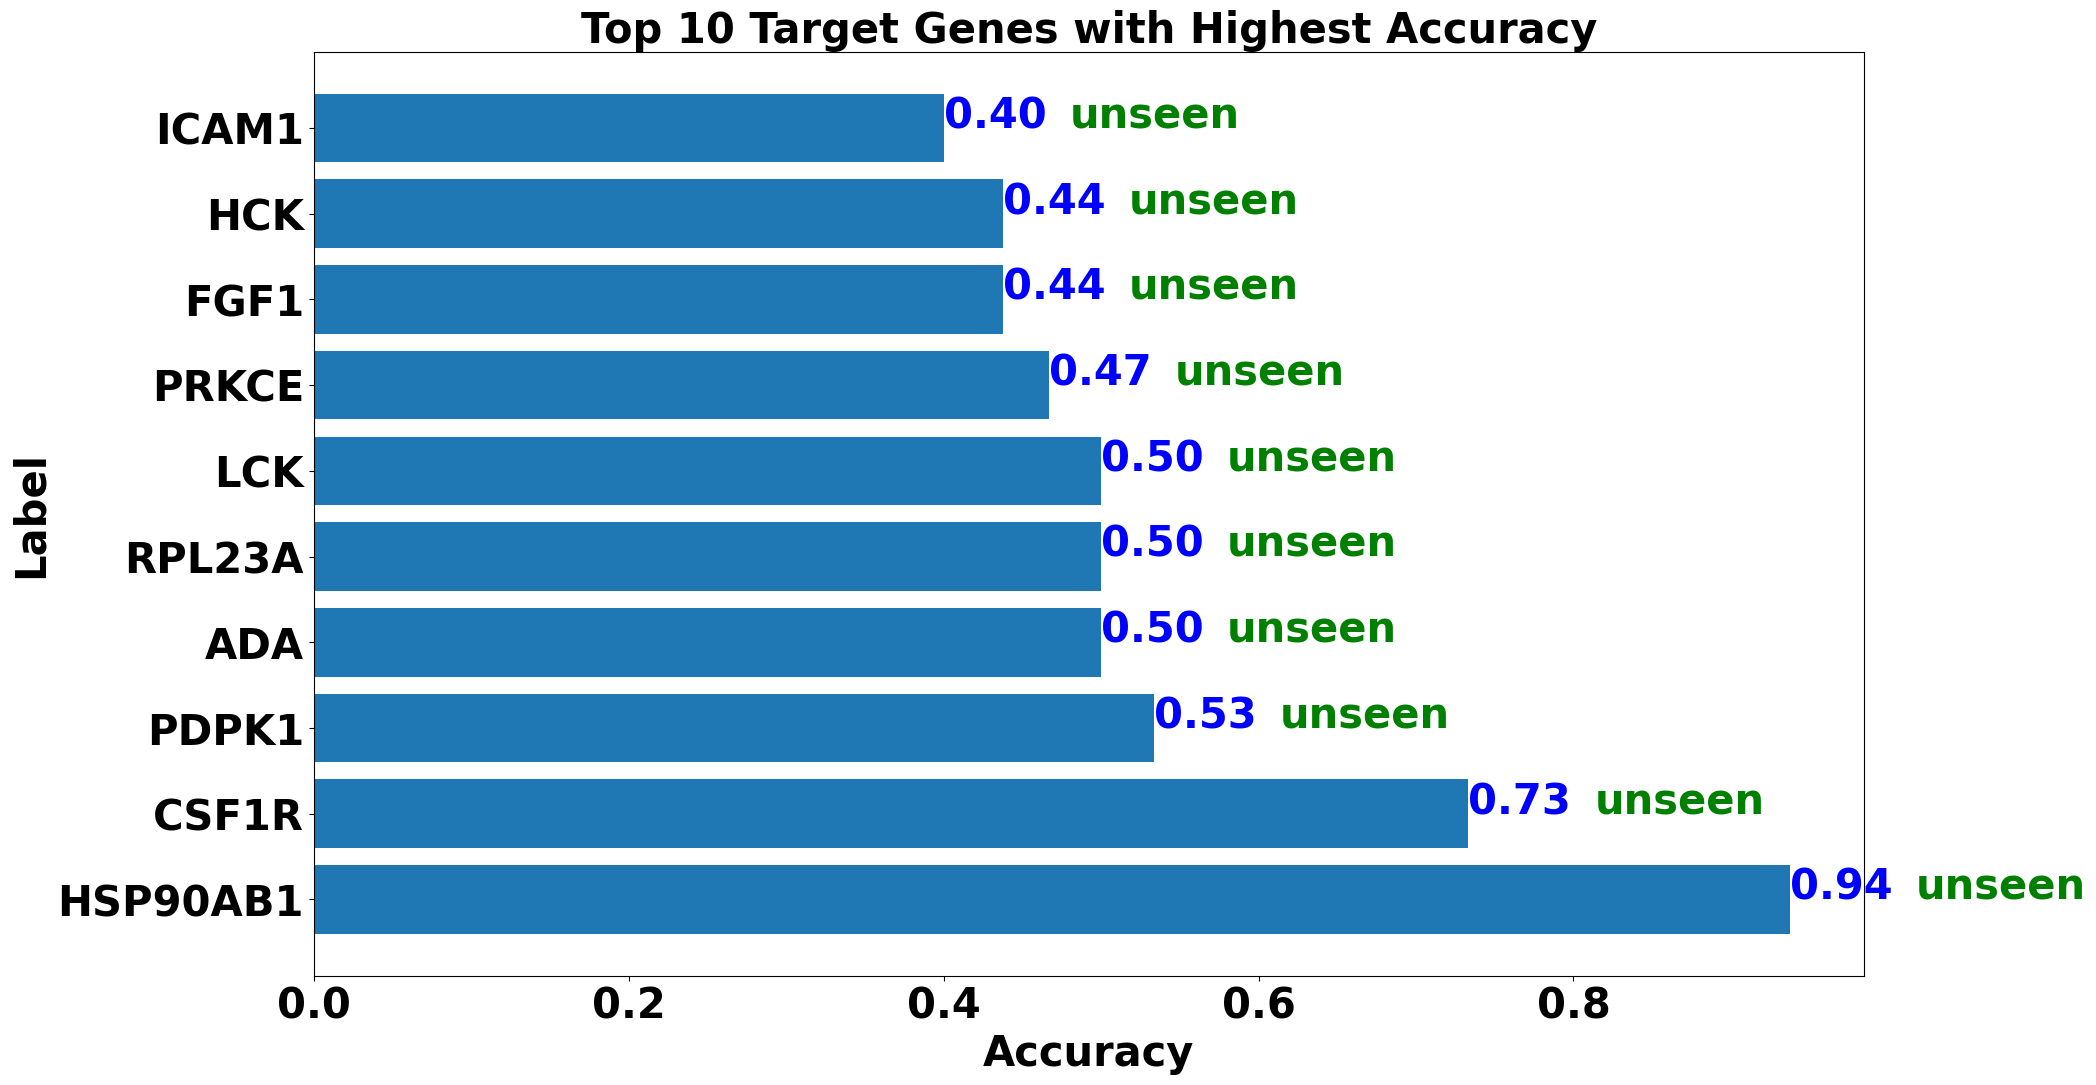

In [44]:
### TOP 10
plt.figure(figsize=(20,12))
plt.barh(df555.index,df555['Recall'])
plt.xlabel('Accuracy',fontweight = 'bold',fontsize=30)
plt.ylabel('Label',fontweight = 'bold',fontsize=30)
plt.yticks(fontweight = 'bold',fontsize=30)
plt.xticks(fontweight = 'bold',fontsize=30)
plt.title('Top 10 Target Genes with Highest Accuracy',fontweight = 'bold',fontsize=30)
for i,(v,s) in enumerate(zip(df555['Recall'],df555['If_seen'])):
    plt.text(v,i,f'{v:.2f}', color = 'blue', fontweight = 'bold',fontsize=30)
    plt.text(v+0.08, i, s, color = 'green', fontweight = 'bold',fontsize=30)
plt.show()